# Anime Recommendations Database

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx

In [77]:
df = pd.read_csv(r"Data/anime.csv")
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Let's check if there are empty cells and the importance of them in relation of the amount of data

In [78]:
df.isna().sum() / df.shape[0]

anime_id    0.000000
name        0.000000
genre       0.005043
type        0.002034
episodes    0.000000
rating      0.018708
members     0.000000
dtype: float64

So, the percentage of empty cells is smaller the 0,1% and I believe that they have very small impact on the overview the dataset, and it is easier to delete rows without some data.

In [79]:
df.dropna(inplace = True)
df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

There is no empty cells


I'll make a function which will count number of genres in each anime


In [80]:
def f(s: str):
	s = s.split(", ")
	s = len(s)
	return s


df["genre_count"] = df.genre.apply(f)
df.genre_count

0        4
1        7
2        7
3        2
4        7
        ..
12289    1
12290    1
12291    1
12292    1
12293    1
Name: genre_count, Length: 12017, dtype: int64

In [81]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_count
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7


So, I added the column with the number of genres in each anime

I suppose that the more different genres the more rating is.Let's check if there is a correlation between number of genres and rating.

In [82]:
px.scatter(df, x = "genre_count", y = df.rating, trendline = "ols")

# Добавить название графика

So the correlation can be seen, but it is not very representative, because for example anime with 1 or 2 genres also have different ratings from 1 to 10, and the highest rating has anime with two genres. So probably the correlation is just a coincidence.

Lets check how many animes with different genres 



<Axes: ylabel='count'>

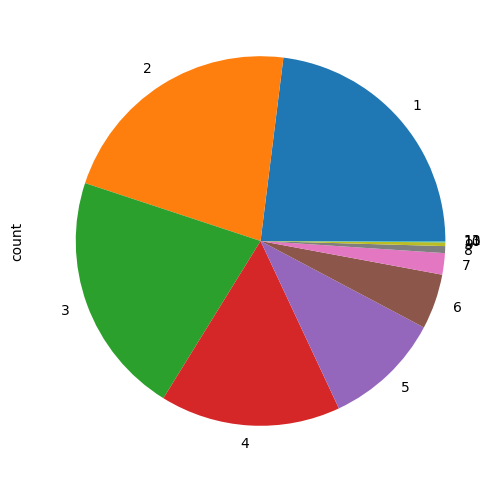

In [83]:
df.genre_count.value_counts().plot.pie(
	figsize = (6, 6)
)

# Добавить заголовок диаграммы

So there is no sence to chaeck animes with more than 7 genres, because the percentage of them is too small. Cosequently the information in previous graph is not relevant а for making such conclusions.

Lets check what genres are the most widespread in this dataset

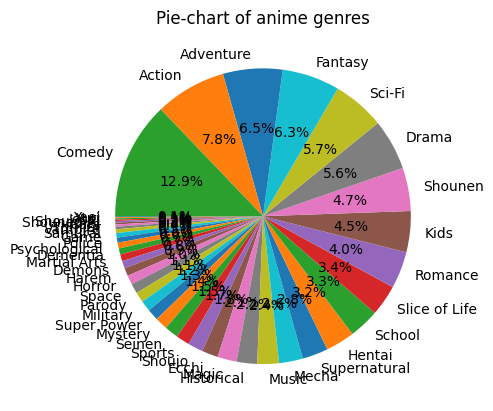

In [84]:
list_df = df.genre.tolist()

result_list = []

for i in list_df:
	for j in i.split(", "):
		result_list.append(j)

counts = {}
for item in result_list:
	counts[item] = counts.get(item, 0) + 1

counts = dict(sorted(counts.items(), key = lambda item: item[1], reverse = False))

labels = list(counts.keys())
values = list(counts.values())

plt.pie(values, labels = labels, autopct = '%1.1f%%', startangle = 180)

plt.title('Pie-chart of anime genres')

plt.show()

So it is no sence to consider anime with genres less than 3% widespreadness, because the sample is too small to make any conclusions about anime with theese genres.

But lets check what genres are in the top of the rating.
Firstly I will sort the dataset by rating.

<Axes: ylabel='count'>

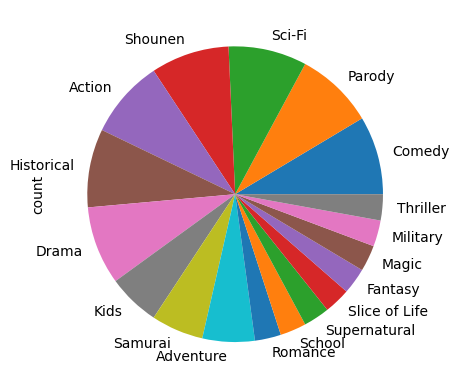

In [85]:
pd.Series(df.sort_values(by = "rating", ascending = False)[:10].genre.apply(
	lambda x: x.split(", ")).sum()).value_counts().plot.pie()

# Добавить заголовок диаграммы

iSo in the top 10 of the rating is also a big range of genres.

I want to make a graph and make all episodes numers integers, so I have to drop str elements.

In [86]:

df.loc[df["episodes"] == "Unknown"].value_counts().sum() / df.shape[0]

0.015561288175085296

The percentage is very small, so we can just drop this rows

In [87]:
df = df[df.episodes != "Unknown"]
df.loc[df["episodes"] == "Unknown"].value_counts().sum() / df.shape[0]

0.0

In [88]:
df.episodes = df.episodes.astype(int)

I'll make a graph which can express correlation between rating, members, type and number of episodes.

In [89]:
# df.episodes.astype(int)
fig = px.scatter(df, x = "rating", y = "members",
				 size = "episodes", color = "type",
				 hover_name = "name", size_max = 60)
fig.show()

# Добавить заголовок статистики, сделать вывод

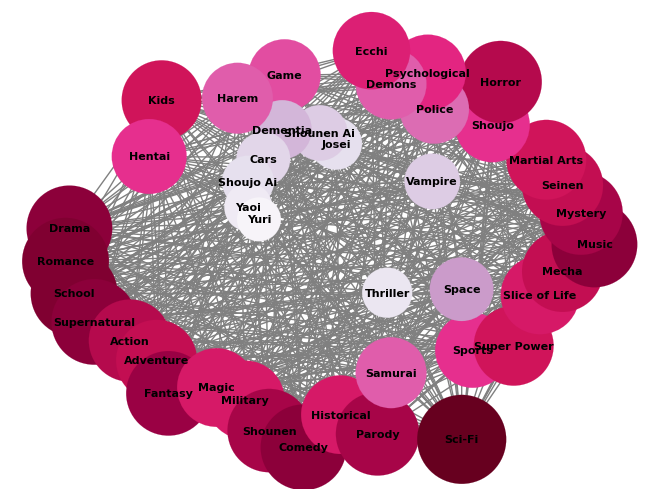

In [90]:
G = nx.Graph()


def connections(s):
	nodes = s.split(", ")
	G.add_nodes_from(nodes)
	edges = [(nodes[i], nodes[i + 1]) for i in range(len(nodes) - 1)]
	G.add_edges_from(edges)


df['genre'].apply(connections)
node_sizes = [G.degree(node) * 100 for node in G.nodes]
node_colors = [G.degree(node) for node in G.nodes]
pos = nx.shell_layout(G)
pos = {node: (pos[node][0] * (G.degree(node) + 1), pos[node][1] * (G.degree(node) + 1)) for node in G.nodes}

nx.draw(G, pos, with_labels = True, node_size = node_sizes, node_color = node_colors, cmap = plt.cm.PuRd, font_size = 8,
		font_color = 'black', font_weight = 'bold', edge_color = 'gray', linewidths = 0.1)

plt.show()

# Дать название

So, the graph shows that many of genres are connected with each other, but there is a genre which usually goes with a lot of genres. It is ski-fi

I suppose that the less episodes the more members.

In [91]:
px.scatter(df, x = df.episodes, y = df.members)

# Добавть заголовок для статистики и дополнить вывод

So, my assumption is true. 

# Гипотеза
## Зависимость популярности от пересечения жанров и от продолжительности